# 1 layer QG code

In [1]:
# Enable interactive plot
# %matplotlib notebook
import numpy as np
from numpy.fft import fft2, ifft2
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cmocean
from IPython.display import HTML

In [37]:
L = 1000e3
W = 1000e3
H = 500
g = 9.81*0.001
nx = 128
ny = 128
dx = L/nx
dy = W/ny
x, y = np.meshgrid(np.arange(1/2, nx)/nx*L-L/2, np.arange(1/2, ny)/ny*W-W/2)
f0 = 1e-4
invLd2 = f0**2/(g*H)
beta = 1e-11

In [3]:
k0x = 2*np.pi/L
k0y = 2*np.pi/W
k0x=2*np.pi/L #calculates smallest wavenumbers from domain size
k0y=2*np.pi/W

# initialises k,l to be evenly spaced in fourier space with (k,l)>(k0xmk0y)
kcoord = k0x*np.arange(0, nx/2+1)
kcoord = np.append(kcoord, k0x*np.arange(-nx/2+1, 0))
lcoord = k0y*np.arange(0, ny/2+1)
lcoord = np.append(lcoord, k0y*np.arange(-ny/2+1, 0))

k, l = np.meshgrid(kcoord, lcoord)
# k = k.astype('complex128')
# l = l.astype('complex128')


In [4]:
invLd2**(-0.5)/1e3

22.147234590350102

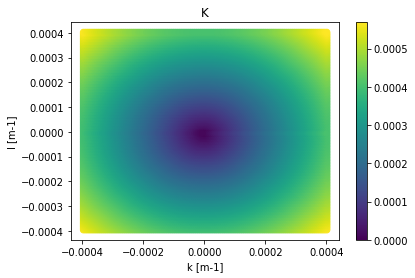

In [5]:
K = (k**2+l**2)**0.5
plt.scatter(k,l,c=K)
plt.colorbar()
plt.xlabel('k [m-1]')
plt.ylabel('l [m-1]')
plt.title('K')
plt.savefig('hw5_2b.png')

In [6]:
if(nx==128):
    cphi = 0.69*np.pi 
elif(nx==256):
	cphi = 0.715*np.pi 
elif(nx==512):
	cphi = 0.735*np.pi 
else:
	cphi = 0.65*np.pi 

wvx=np.sqrt(K**2)*dx 
filtr=np.exp(-18*(wvx-cphi)**7)*(wvx>cphi)+(wvx<=cphi);
filtr[np.isnan(filtr)]=1

wv2 = k*k + l*l
kmax2=((nx/2-1)*k0x)**2
trunc= (wv2<kmax2)

<ipython-input-6-643c417672fb>:11: RuntimeWarning: overflow encountered in exp
  filtr=np.exp(-18*(wvx-cphi)**7)*(wvx>cphi)+(wvx<=cphi);
<ipython-input-6-643c417672fb>:11: RuntimeWarning: invalid value encountered in multiply
  filtr=np.exp(-18*(wvx-cphi)**7)*(wvx>cphi)+(wvx<=cphi);


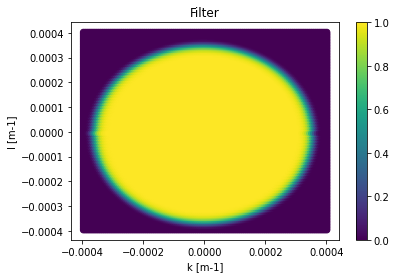

In [7]:
plt.scatter(k,l,c=filtr)
plt.colorbar()
plt.xlabel('k [m-1]')
plt.ylabel('l [m-1]')
plt.title('Filter')
plt.savefig('hw5_2c.png')

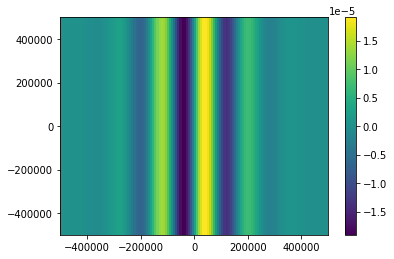

In [8]:
q=0.2*f0*np.exp(-(x/(L/5))**2)*np.sin(12*np.pi*x/L)
plt.pcolormesh(x,y,q)
plt.colorbar()

/Users/scott/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


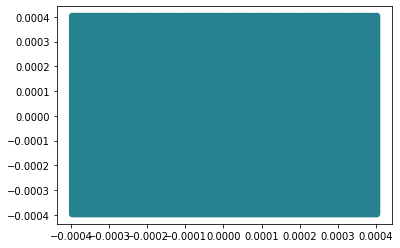

In [10]:
plt.scatter(k,l,c=qh)

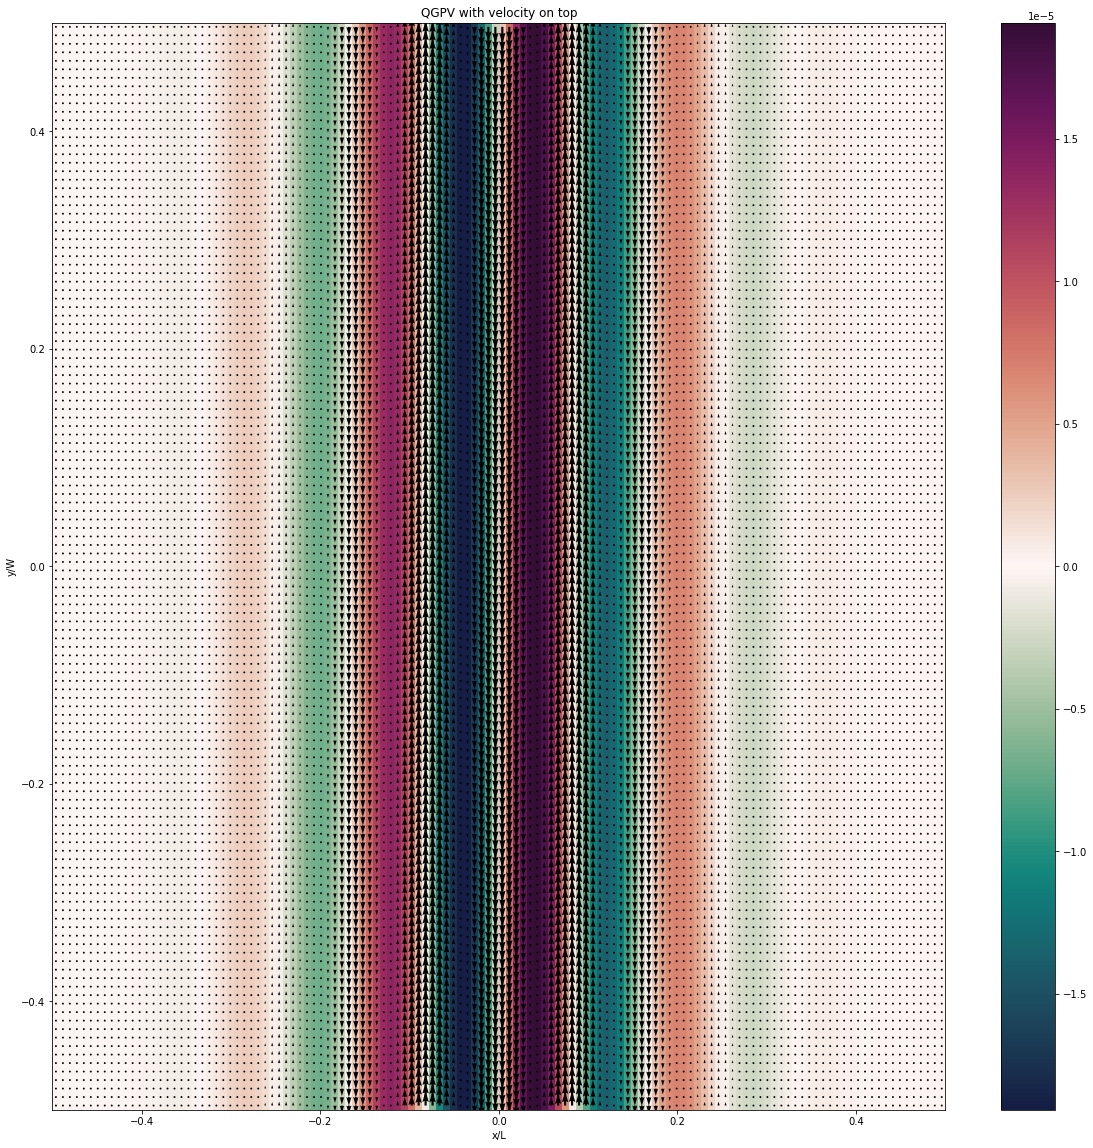

In [12]:
qh = fft2(q)
psih = -qh/(K**2+invLd2) # ft of psi
u=-np.real(ifft2(1j*l*psih))
v=np.real(ifft2(1j*k*psih))

plt.figure(figsize = (20,20))
plt.pcolormesh(x/L,y/W,q,cmap=cmocean.cm.curl)
plt.colorbar()
# idx = 4*np.arange(nx/4)
plt.quiver(x/L,y/W,u,v)
plt.xlabel('x/L')
plt.ylabel('y/W')
plt.title('QGPV with velocity on top')
plt.savefig('hw5_2d.png')

In [47]:
dt = 4*3600 # 4 hour time step
def caluv(qh,k,l):
    psih = -qh/(K**2+invLd2) # ft of psi
    u=-np.real(ifft2(1j*l*psih))
    v=np.real(ifft2(1j*k*psih))
    
    return u, v
t=0
count = 0
nyears = 10
tmax = 24*3600*365*nyears
u_plot = np.zeros((128,128,(int(tmax/dt)+1)//20))
v_plot = np.zeros((128,128,(int(tmax/dt)+1)//20))
q_plot = np.zeros((128,128,(int(tmax/dt)+1)//20))
psi_plot = np.zeros((128,128,(int(tmax/dt)+1)//20))
print(u_plot.shape)
# q1 = 0.2*f0*np.exp(-(x/(L/5))**2)*np.sin(12*np.pi*x/L)
q1 = 0.2*f0*np.exp(-(x/(L/5))**2)*np.sin(4*np.pi*x/L)
qh1 = fft2(q1)
while t<tmax:
    psih = -qh1/(K**2+invLd2)
    u,v = caluv(qh1,k,l)
    q1 = np.real(ifft2(qh1))
    dqh_dt1 = -1j*k*fft2(u*q1)-1j*l*fft2(v*q1)-1j*beta*k*psih
    if t==0:
        dqh_dt0 = dqh_dt1.copy()
        qh0 = qh1.copy()
    qh2 = (qh1+1.5*dt*dqh_dt1-0.5*dt*dqh_dt0)*filtr
    qh1 = qh2.copy()
    qh0 = qh1.copy()
    dqh_dt0 = dqh_dt1.copy()
    if count%20==0:
        u_plot[:,:,int(count/20)] = u
        v_plot[:,:,int(count/20)] = v
        q_plot[:,:,int(count/20)] = q1
        psi_plot[:,:,int(count/20)] = np.real(ifft2(psih))
    if count%1000==0:
        print(t/(24*3600*365))
    t+=dt
    count+=1
   

(128, 128, 1095)
0.0
0.45662100456621
0.91324200913242
1.36986301369863
1.82648401826484
2.2831050228310503
2.73972602739726
3.1963470319634704
3.65296803652968
4.109589041095891
4.566210045662101
5.0228310502283104
5.47945205479452
5.936073059360731
6.392694063926941
6.8493150684931505
7.30593607305936
7.762557077625571
8.219178082191782
8.67579908675799
9.132420091324201
9.58904109589041


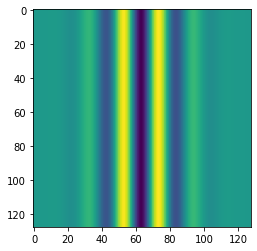

In [13]:
plt.imshow(v_plot[:,:,100])

In [22]:
q_plot.shape

(128, 128, 1095)

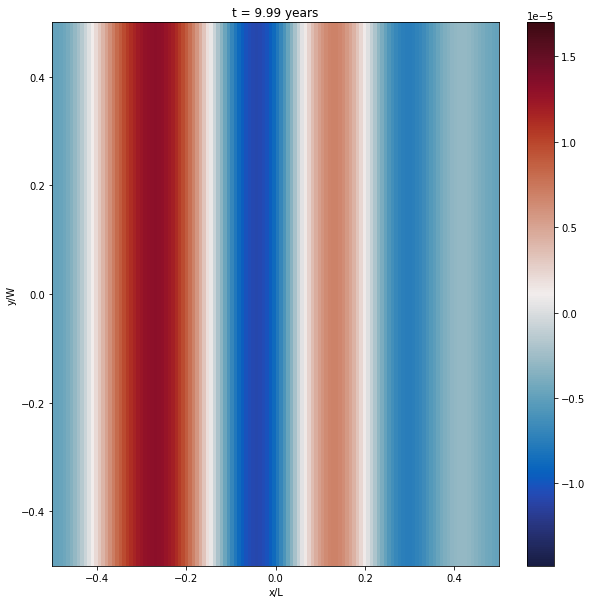

In [27]:
# Create the figure and axis
fig, ax = plt.subplots(figsize = (10,10))

# Create the initial pcolormesh plot
pcm = ax.pcolormesh(x/L, y/L, q_plot[:,:,0], shading='auto', vmin = np.nanmin(q_plot), vmax=np.nanmax(q_plot), cmap=cmocean.cm.balance)
fig.colorbar(pcm, ax=ax)  # Add colorbar
ax.set_xlabel('x/L')
ax.set_ylabel('y/W')

# Update function for animation
def update(frame):
    # Update the data for the pcolormesh plot
    c_new = q_plot[:,:,frame]
    pcm.set_array(c_new.ravel())  # Update the data
    ax.set_title(f't = {round(nyears*frame/u_plot.shape[-1],2)} years')

# Create the animation
anim = FuncAnimation(fig, update, frames=q_plot.shape[-1], interval=10)

# Display the animation in the Jupyter Notebook
HTML(anim.to_html5_video())


AttributeError: 'list' object has no attribute 'set_ydata'

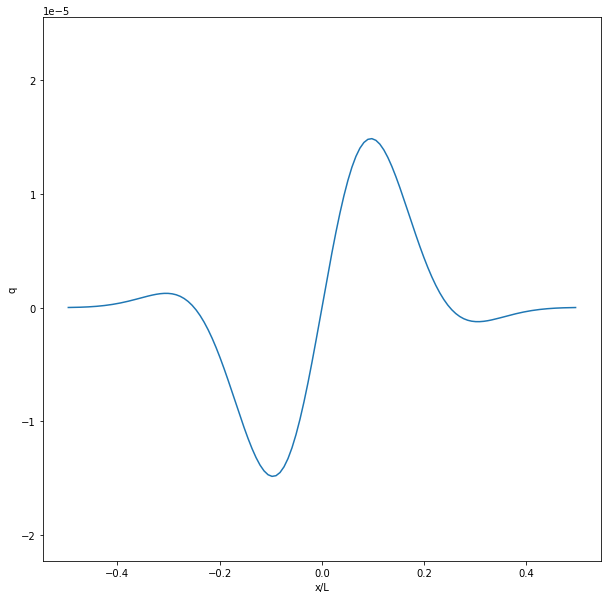

In [38]:
# Create the figure and axis
fig, ax = plt.subplots(figsize = (10,10))

# Create the initial pcolormesh plot
line = ax.plot(x[64,:]/L,q_plot[64,:,0])#, shading='auto', vmin = np.nanmin(q_plot), vmax=np.nanmax(q_plot), cmap=cmocean.cm.balance)
# fig.colorbar(pcm, ax=ax)  # Add colorbar
ax.set_xlabel('x/L')
ax.set_ylabel('q')
ax.set_ylim([1.5*np.nanmin(q_plot), 1.5*np.nanmax(q_plot)])

# Update function for animation
def update(frame):
    # Update the data for the pcolormesh plot
    c_new = q_plot[64,:,frame]
    line.set_ydata(c_new)  # Update the data
    ax.set_title(f't = {round(nyears*frame/u_plot.shape[-1],2)} years')

# Create the animation
anim = FuncAnimation(fig, update, frames=q_plot.shape[-1], blit=True, interval=10)

# Display the animation in the Jupyter Notebook
HTML(anim.to_html5_video())


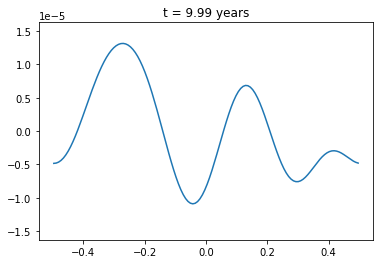

In [48]:

fig, ax = plt.subplots()

x_plot = x[64,:]/L
line, = ax.plot(x_plot, q_plot[64,:,0])


def animate(i):
    line.set_ydata(q_plot[64,:,i])  # update the data.
    ax.set_title(f't = {round(nyears*i/u_plot.shape[-1],2)} years')
    return line,


ani = FuncAnimation(
    fig, animate, frames=q_plot.shape[-1],interval=10)

# Display the animation in the Jupyter Notebook
HTML(ani.to_html5_video())